In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Hello World
This tutorial/example aims to give an simplistic overview of setting up a passive volume (scattering material to be imaged), detector (active material to record hits), and optimisation loop (to refine the detector to image the passive volume better or more cheaply)


## Volume setup
The volume consists of both passive material to be imaged, and active detectors to record muons hits. We aim to adjust the resolution and efficiency of the detectors to minimise the cost of the detector whilst improving the precision of the imaging of the passive volume.

<img src="imgs/volume_layout.png" width="256">

The above image shows a typical layout, with two detection layers above and below the passive volume consisting of layers of material. Each layer consists of sub-cubes (voxels). In the detector layers, these are elements of the detector with properties to be optimised, and in the passive layers these can be different materials, whose X0 will affect the scattering of muons to deferring extents.

We need to define the cost of the detector elements according to resolution and efficiency. These are currently arbitrary, and discussed further in the next tutorial:

In [2]:
import torch
from torch import Tensor
from torch.nn import functional as F

import matplotlib.pyplot as plt
import seaborn as sns

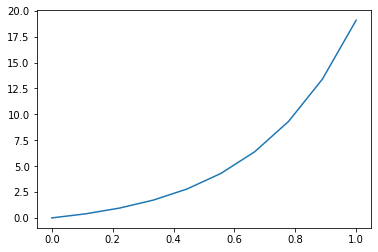

In [3]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))  # free for negative efficiency, sharp rise as efficiency increases

x = torch.linspace(0,1,10)
plt.plot(x, eff_cost(x))

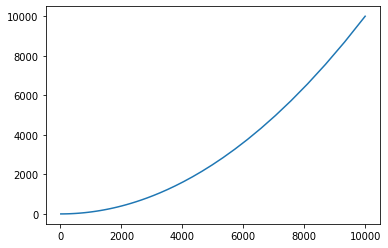

In [4]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x/100)**2  # free for negative resoltuion, gradual rise as resoltuion increases

x = torch.logspace(1,4,100)
plt.plot(x, res_cost(x))

Construct a volume by sandwiching passive layers with pairs of detector layers above and below. Detector layers are initialised with a specified resolution and efficiency for each element. Passive layers will contain voxels of different materials.

In [5]:
import numpy as np
from torch import nn
from tomopt.volume import PassiveLayer, VoxelDetectorLayer

In [6]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(VoxelDetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res,
                                        lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost))
        else:
            pos = 'below'
            layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

We'll feed these stacked layers into a single object for convenience.

In [7]:
from tomopt.volume import Volume

In [8]:
volume = Volume(get_layers())
volume

Volume(
  (layers): ModuleList(
    (0): VoxelDetectorLayer()
    (1): VoxelDetectorLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PassiveLayer()
    (8): VoxelDetectorLayer()
    (9): VoxelDetectorLayer()
  )
)

## Optimisation

Having built our detector and defined where the passive volumes will be, we now want to define the material composition of the passive volume(s) to be imaged, and to optimise our detector.
As its name suggests, `VoxelVolumeWrapper` wraps the `Volume` and provides methods to optimise the detector, predict passive volumes, loading and saving of detector configurations, etc.

When building the wrapper, we need to supply it with optimiser definitions for both resolution and efficiency, and a loss function to optimise. Optimisers are the classes in PyTorch which implement gradient descent on specified parameters. For the optimisers, use partial definitions, since the `VoxelVolumeWrapper` takes care of instantiating the optimisers to relate to the relevant detector parameters.

In [9]:
from functools import partial
from tomopt.optimisation import VoxelVolumeWrapper, DetectorLoss

In [10]:
wrapper = VoxelVolumeWrapper(volume,
                             res_opt=partial(torch.optim.SGD, lr=2e9),  # Scale of resolution is large, so use high LR
                             eff_opt=partial(torch.optim.SGD, lr=2e4),  # Scale of efficiency is [0,1] so use smaller LR
                             loss_func=DetectorLoss(cost_coef=None))  # Loss is precision + cost_coef*detector cost, balance coef as required or leave as None to automatically balance on first batch

Now we need to define the composition of the passive volume. This is done via a function which is called per passive layer (we have six) and returns the x0 (radiation length [m]) of the material in the voxels in that layer. Below we'll define the passive material to be mostly beryllium but with a single block of lead in the corner of one of the layers.

In [11]:
from tomopt.core import X0

In [12]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

Since we may want to optimise the detector for multiple different passive volumes (or randomly generated volumes), different functions can be passed to the `VoxelVolumeWrapper` during optimisation by loading the functions into `PassiveYielder` objects, which loop through the passive volumes. In this tutorial, though, we only have one passive volume.

In [13]:
from tomopt.optimisation import PassiveYielder

In [14]:
passives = PassiveYielder([arb_rad_length])

Now we're in a position to optimise our detector using the `VolumeWrapper.fit` method. The general layout for the optimisation loop is as follows, where `mu_bs` is the number of muons passed through the volume simultaneously and `passive_bs` is the number of passive volumes used per detector update:
1. for epoch in `n_epochs`:
    1. `loss` = 0
    1. for `p`, `passive` in enumerate(`trn_passives`):
        1. load `passive` into passive volume
        1. for muon_batch in range(`n_mu_per_volume`//`mu_bs`):
            1. Irradiate volume with `mu_bs` muons
            1. Infer passive volume
        1. Compute loss based on precision and cost, and add to `loss`
        1. if `p`+1 % `passive_bs` == 0:
            1. `loss` = `loss`/`passive_bs`
            1. Backpropagate `loss` and update detector parameters
            1. `loss` = 0
        1. if len(`trn_passives`)-(`p`+1) < `passive_bs`:
            1. Break
            
    1. `val_loss` = 0
    1. for `p`, `passive` in enumerate(`val_passives`):
        1. load `passive` into passive volume
        1. for muon_batch in range(`n_mu_per_volume`//`mu_bs`):
            1. Irradiate volume with `mu_bs` muons
            1. Infer passive volume
            1. Compute loss based on precision and cost, and add to `val_loss`
        1. if len(`val_passives`)-(`p`+1) < `passive_bs`:
            1. Break
    1. `val_loss` = `val_loss`/`p`

I.e. the loss for a single passive can be computed over several iterations of muon irradiation (for computational speed), and the total loss can be accumulated over multiple passives before updating the detector. In our case we only have one passive. We also have the option of evaluating the detector on unseen passives via validation data. For this example, we'll use the same passive for the both training and validation.

Additionally, the optimisation loop has many interjection points for callback classes, which can affect most aspects of the optimisation. Currently in TomOpt, there is a problem which means that sometimes the gradients for some parameters are `NaN` after backpropagation. The `tomopt.optimisation.callbacks.grad_callbacks.NoMoreNaNs` will automatically go through each parameter after backpropagation and replace `NaN` gradients with zeros prior to the optimiser update step. Additionally, it is useful to have an indication of the progress the optimisation, and the current state of the detector. `tomopt.optimisation.callbacks.monitors.MetricLogger` provides real-time progress updates and telemetric data.

In [15]:
from tomopt.optimisation import NoMoreNaNs, VoxelMetricLogger

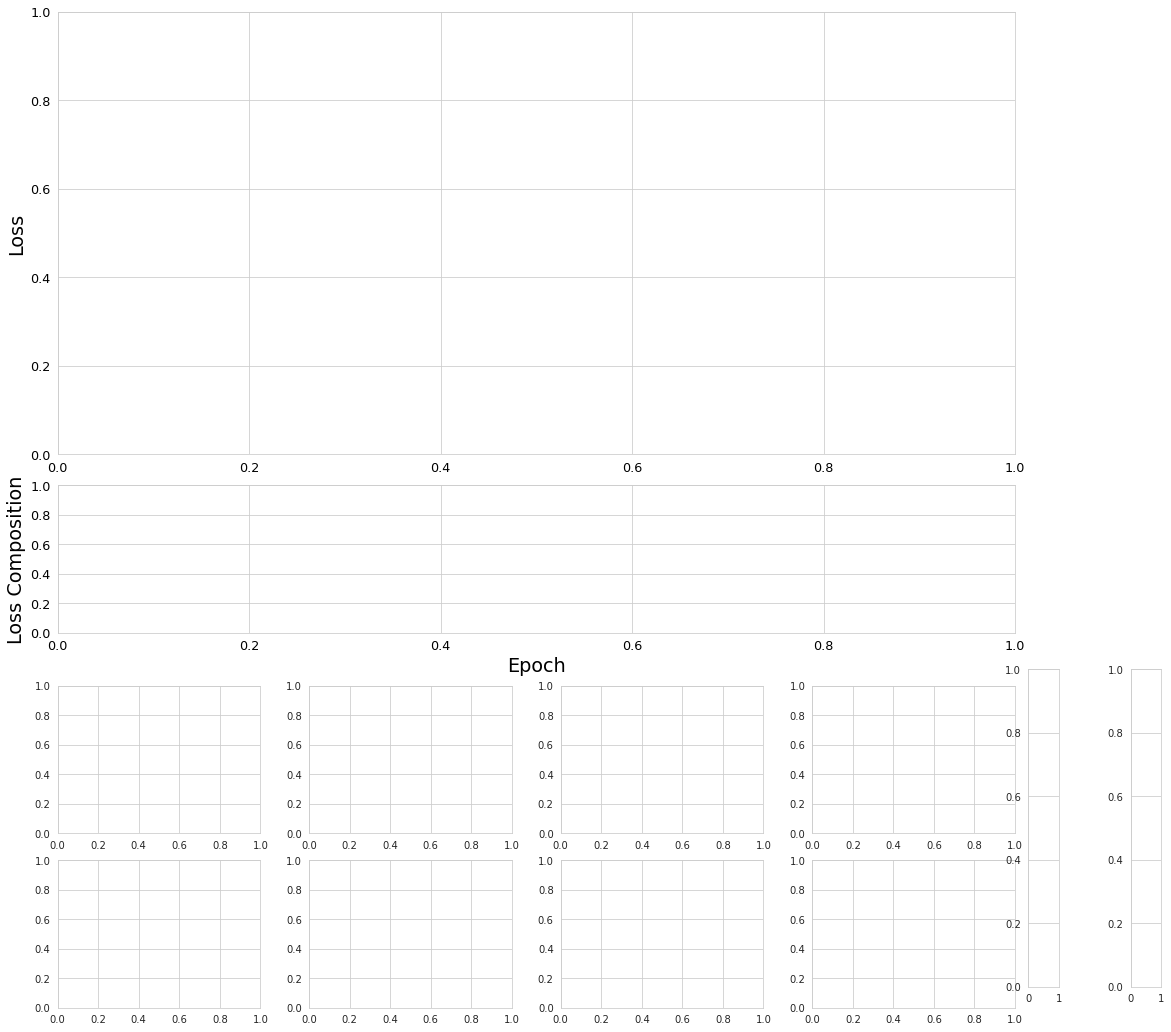

In [ ]:
_ = wrapper.fit(n_epochs=10,
                passive_bs=1,
                n_mu_per_volume=1000,
                mu_bs=100,
                trn_passives=passives,
                val_passives=passives,
                cbs=[NoMoreNaNs(),VoxelMetricLogger()])

The initial resolution of each detector element was $1000 m^{-1}$ and the initial efficiencies were 0.5. From this we can see that the resolutions and efficiencies generally increase. Running for longer will produce a more prominent (and asymmetric) change in the four detector layers.

## Predictions
`VolumeWrapper` also has a `.predict` method to provide predictions per passive volume. For convenience it also returns the true material composition for each prediction.

In [ ]:
preds = wrapper.predict(passives,
                        n_mu_per_volume=10000,
                        mu_bs=100)

`preds` is a list of tuples of predicted x0 and true x0 per passive volume. We can plot these with `tomopt.plotting.predictions.plot_pred_true_x0`.

In [ ]:
from tomopt.plotting import plot_pred_true_x0

In [ ]:
plot_pred_true_x0(*preds[0])

Above we have the predicted and true x0 for ever voxel in the six passive layers. Currently the scale of predictions is very low, due to biases in the prediction method, however we can already see some indication of the lead block in the relative values of the predictions. Running 100k muons, will make the asymmetry more prominent, however that takes about 8 minutes.